In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=7561cc3008822222811ea42838b36cb547ff65e64a386cf71f3dec08f18a62de
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=130433bc64080170b13f5ff313e58017d087e3d2e5486f93b1c4b5202c9f35ef
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 23.68 MiB/s, done.


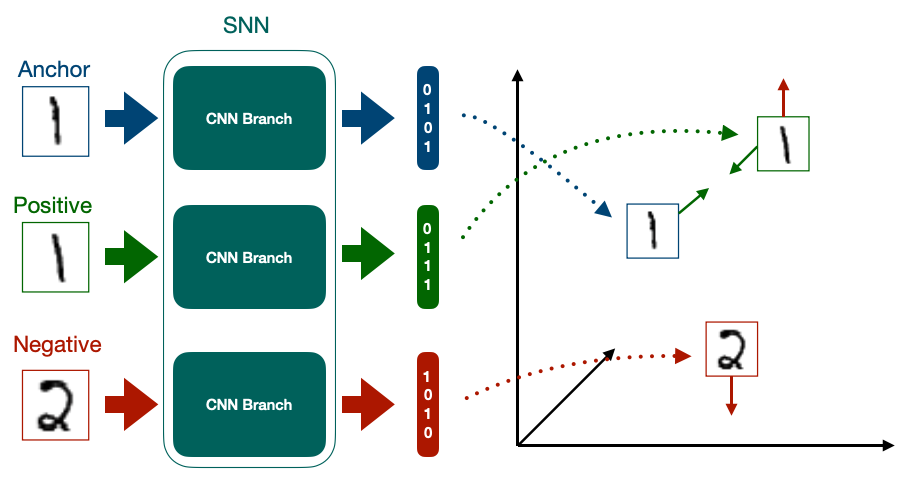

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
#Define file path
data_dir = '/content/Person-Re-Id-Dataset/train/'
csv_file = '/content/Person-Re-Id-Dataset/train.csv'

#Define hyperparameter
batch_size = 16
learning_rate = 1e-2
epoch = 20

#Define device
device = 'cuda'

In [6]:
data_df = pd.read_csv(csv_file)
data_df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


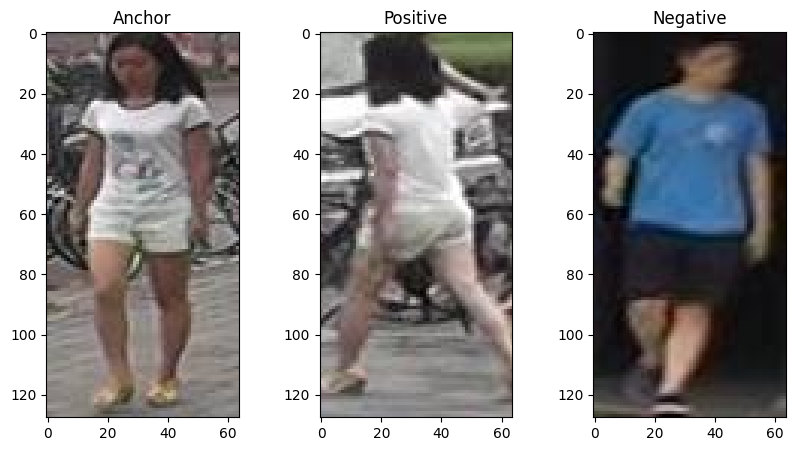

In [7]:
row = data_df.iloc[10]

#Read image
anchor = io.imread(data_dir + row['Anchor'])
positive = io.imread(data_dir + row['Positive'])
negative = io.imread(data_dir + row['Negative'])

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

#Draw image using plt
ax1.set_title('Anchor')
ax1.imshow(anchor)

ax2.set_title('Positive')
ax2.imshow(positive)

ax3.set_title('Negative')
ax3.imshow(negative)

In [8]:
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=42)

# Create APN Dataset

In [9]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    #Read image
    anchor = io.imread(data_dir + row['Anchor'])
    positive = io.imread(data_dir + row['Positive'])
    negative = io.imread(data_dir + row['Negative'])

    #Change dimension of image: (h, w, c) -> (c, h, w)
    anchor = torch.from_numpy(anchor).permute(2, 0, 1) / 255.0
    positive = torch.from_numpy(positive).permute(2, 0, 1) / 255.0
    negative = torch.from_numpy(negative).permute(2, 0, 1) / 255.0

    return anchor, positive, negative


In [10]:
train_dataset = APN_Dataset(train_df)
valid_dataset = APN_Dataset(valid_df)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

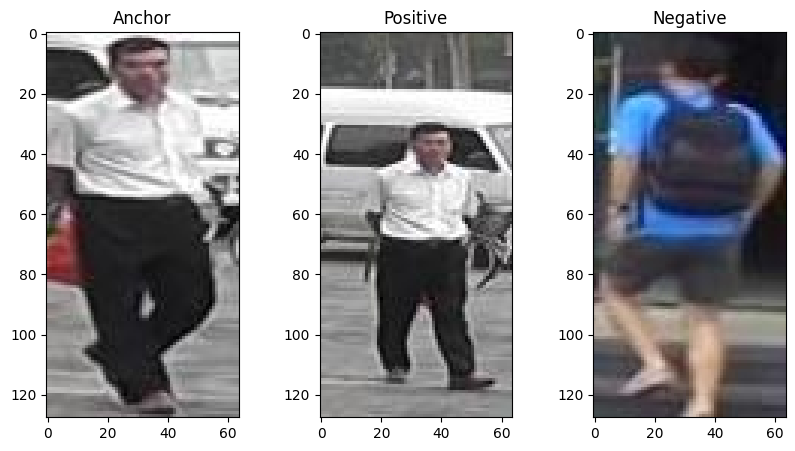

In [11]:
idx = 30
A,P,N = train_dataset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

#Transpose the image: (c, h, w) -> (h, w, c)
ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [12]:
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [13]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 200
No. of batches in validloader : 50


In [14]:
for A, P, N in trainloader:
  print(f"One image batch shape : {A.shape}")
  break

One image batch shape : torch.Size([16, 3, 128, 64])


# Create Model

In [15]:
class APN_Model(nn.Module):

  def __init__(self, embedding_size = 512):
    super(APN_Model, self).__init__()

    self.embedding_size = embedding_size
    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=embedding_size)

  def forward(self, image):
    embeddings = self.efficientnet(image)
    return embeddings

In [37]:
model = APN_Model(1024)
model.to(device)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [17]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train()
  train_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A = A.to(device)
    P = P.to(device)
    N = N.to(device)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  return train_loss / len(dataloader)

In [18]:
def eval_fn(model, dataloader, criterion):

  model.train()
  eval_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A = A.to(device)
    P = P.to(device)
    N = N.to(device)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    eval_loss += loss.item()

  return eval_loss / len(dataloader)

In [19]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Create Training Loop

In [20]:
best_eval_loss = np.Inf

for i in range(epoch):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  eval_loss = eval_fn(model, validloader, criterion)

  if best_eval_loss > eval_loss:
    best_eval_loss = eval_loss
    torch.save(model.state_dict(), 'best_model.pt')
    print("Checkpoint saved")

  print(f"Epochs: {i + 1} train loss: {train_loss} eval loss; {eval_loss}")

100%|██████████| 50/50 [00:03<00:00, 12.93it/s]


Checkpoint saved
Epochs: 1 train loss: 2.0422220401838422 eval loss; 0.44117630526423457


100%|██████████| 50/50 [00:03<00:00, 13.21it/s]


Checkpoint saved
Epochs: 2 train loss: 0.37029389303177596 eval loss; 0.3621867600083351


100%|██████████| 50/50 [00:04<00:00, 10.42it/s]


Checkpoint saved
Epochs: 3 train loss: 0.2767846920341253 eval loss; 0.3101626282930374


100%|██████████| 50/50 [00:03<00:00, 13.56it/s]


Checkpoint saved
Epochs: 4 train loss: 0.22742097243666648 eval loss; 0.26631414458155633


100%|██████████| 50/50 [00:04<00:00, 11.45it/s]


Checkpoint saved
Epochs: 5 train loss: 0.1991022900864482 eval loss; 0.2312118510901928


100%|██████████| 50/50 [00:04<00:00, 12.25it/s]


Checkpoint saved
Epochs: 6 train loss: 0.1716413951292634 eval loss; 0.16473138213157654


100%|██████████| 50/50 [00:03<00:00, 13.07it/s]


Epochs: 7 train loss: 0.14455969784408806 eval loss; 0.18586231730878353


100%|██████████| 50/50 [00:04<00:00, 10.58it/s]


Epochs: 8 train loss: 0.14069952089339494 eval loss; 0.2357820275425911


100%|██████████| 50/50 [00:03<00:00, 13.14it/s]


Checkpoint saved
Epochs: 9 train loss: 0.1412334093078971 eval loss; 0.14851271390914916


100%|██████████| 50/50 [00:03<00:00, 13.40it/s]


Epochs: 10 train loss: 0.13370402056723832 eval loss; 0.22108642414212226


100%|██████████| 50/50 [00:04<00:00, 10.60it/s]


Epochs: 11 train loss: 0.12162213400006294 eval loss; 0.21128321647644044


100%|██████████| 50/50 [00:03<00:00, 13.90it/s]


Epochs: 12 train loss: 0.14471263986080884 eval loss; 0.20953788936138154


100%|██████████| 50/50 [00:03<00:00, 13.41it/s]


Epochs: 13 train loss: 0.13090636786073445 eval loss; 0.18822149693965912


100%|██████████| 50/50 [00:04<00:00, 10.64it/s]


Epochs: 14 train loss: 0.11065818745642901 eval loss; 0.17624418780207635


100%|██████████| 50/50 [00:03<00:00, 13.38it/s]


Epochs: 15 train loss: 0.13347253121435643 eval loss; 0.20482060089707374


100%|██████████| 50/50 [00:03<00:00, 13.31it/s]


Epochs: 16 train loss: 0.12010433908551932 eval loss; 0.17193387895822526


100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


Epochs: 17 train loss: 0.09705442599952221 eval loss; 0.21414558202028275


100%|██████████| 50/50 [00:04<00:00, 11.73it/s]


Checkpoint saved
Epochs: 18 train loss: 0.11500626794993878 eval loss; 0.1247681200504303


100%|██████████| 50/50 [00:03<00:00, 13.78it/s]


Epochs: 19 train loss: 0.16604276597499848 eval loss; 0.1580413717031479


100%|██████████| 50/50 [00:04<00:00, 12.40it/s]

Checkpoint saved
Epochs: 20 train loss: 0.13105626028031112 eval loss; 0.11670453906059265


# Get Anchor Embeddings

In [21]:
def get_anchor_embeddings(model, anc_img_names):
  anc_img_names_list = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_list):
      anchor = io.imread(data_dir + i)
      anchor = torch.from_numpy(anchor).permute(2, 0, 1) / 255.0
      anchor = anchor.to(device)
      anchor_encode = model(anchor.unsqueeze(0))
      encodings.append(anchor_encode.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [22]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_anchor_embeddings(model, data_df["Anchor"])

100%|██████████| 4000/4000 [00:42<00:00, 93.97it/s] 


In [23]:
df_enc.to_csv('anchor_embeddings.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1420_c5s3_052165_01.jpg,-1.319337,-3.890635,2.511778,6.720864,0.467519,-2.593651,2.387660,3.940493,-0.808234,...,3.221743,3.722008,-1.022690,0.193537,2.231281,-1.433063,-0.321008,-2.449035,-5.596690,-1.591982
1,1420_c3s3_061978_03.jpg,-1.352179,-3.876047,2.510054,6.720943,0.485209,-2.653265,2.372302,3.861799,-0.814114,...,3.259982,3.749650,-1.037597,0.229947,2.182034,-1.404691,-0.337349,-2.456227,-5.597359,-1.599578
2,1420_c5s3_062565_05.jpg,-1.342985,-3.911445,2.522960,6.777986,0.478838,-2.650074,2.376049,3.912205,-0.815093,...,3.254657,3.762776,-1.007942,0.237249,2.168992,-1.396377,-0.323411,-2.456059,-5.651726,-1.547170
3,1420_c6s3_085592_04.jpg,-1.281056,-3.917886,2.522132,6.725622,0.460566,-2.605179,2.370980,4.005248,-0.790158,...,3.210670,3.702203,-0.972498,0.180883,2.275965,-1.439762,-0.284701,-2.464680,-5.643145,-1.545467
4,0663_c5s3_085987_03.jpg,-1.160957,-4.012195,2.527180,6.963644,0.284465,-2.440948,2.427947,4.449332,-0.858997,...,3.050453,3.599265,-0.841151,-0.006135,2.411958,-1.404860,-0.140853,-2.392918,-5.803071,-1.438925


# Inference

In [24]:
def euclidean_distance(img_encode, anc_encode):
  return np.linalg.norm(img_encode - anc_encode)

In [64]:
idx = 10
img_name = df_enc['Anchor'][idx]
img_path = data_dir + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
model.to('cpu')

model.eval()
with torch.no_grad():
  img_encode = model(img.unsqueeze(0))
  img_encode = img_encode.detach().cpu().numpy()

In [65]:
anc_encode_list = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [66]:
distance = []

for i in range(anc_encode_list.shape[0]):
  distance.append(euclidean_distance(img_encode, anc_encode_list[i : i + 1, :]))

distance = np.array(distance)
print(distance)

[89.47292  89.70521  90.42939  ... 90.61165  90.395775 90.33358 ]


In [67]:
closest_idx = np.argsort(distance)

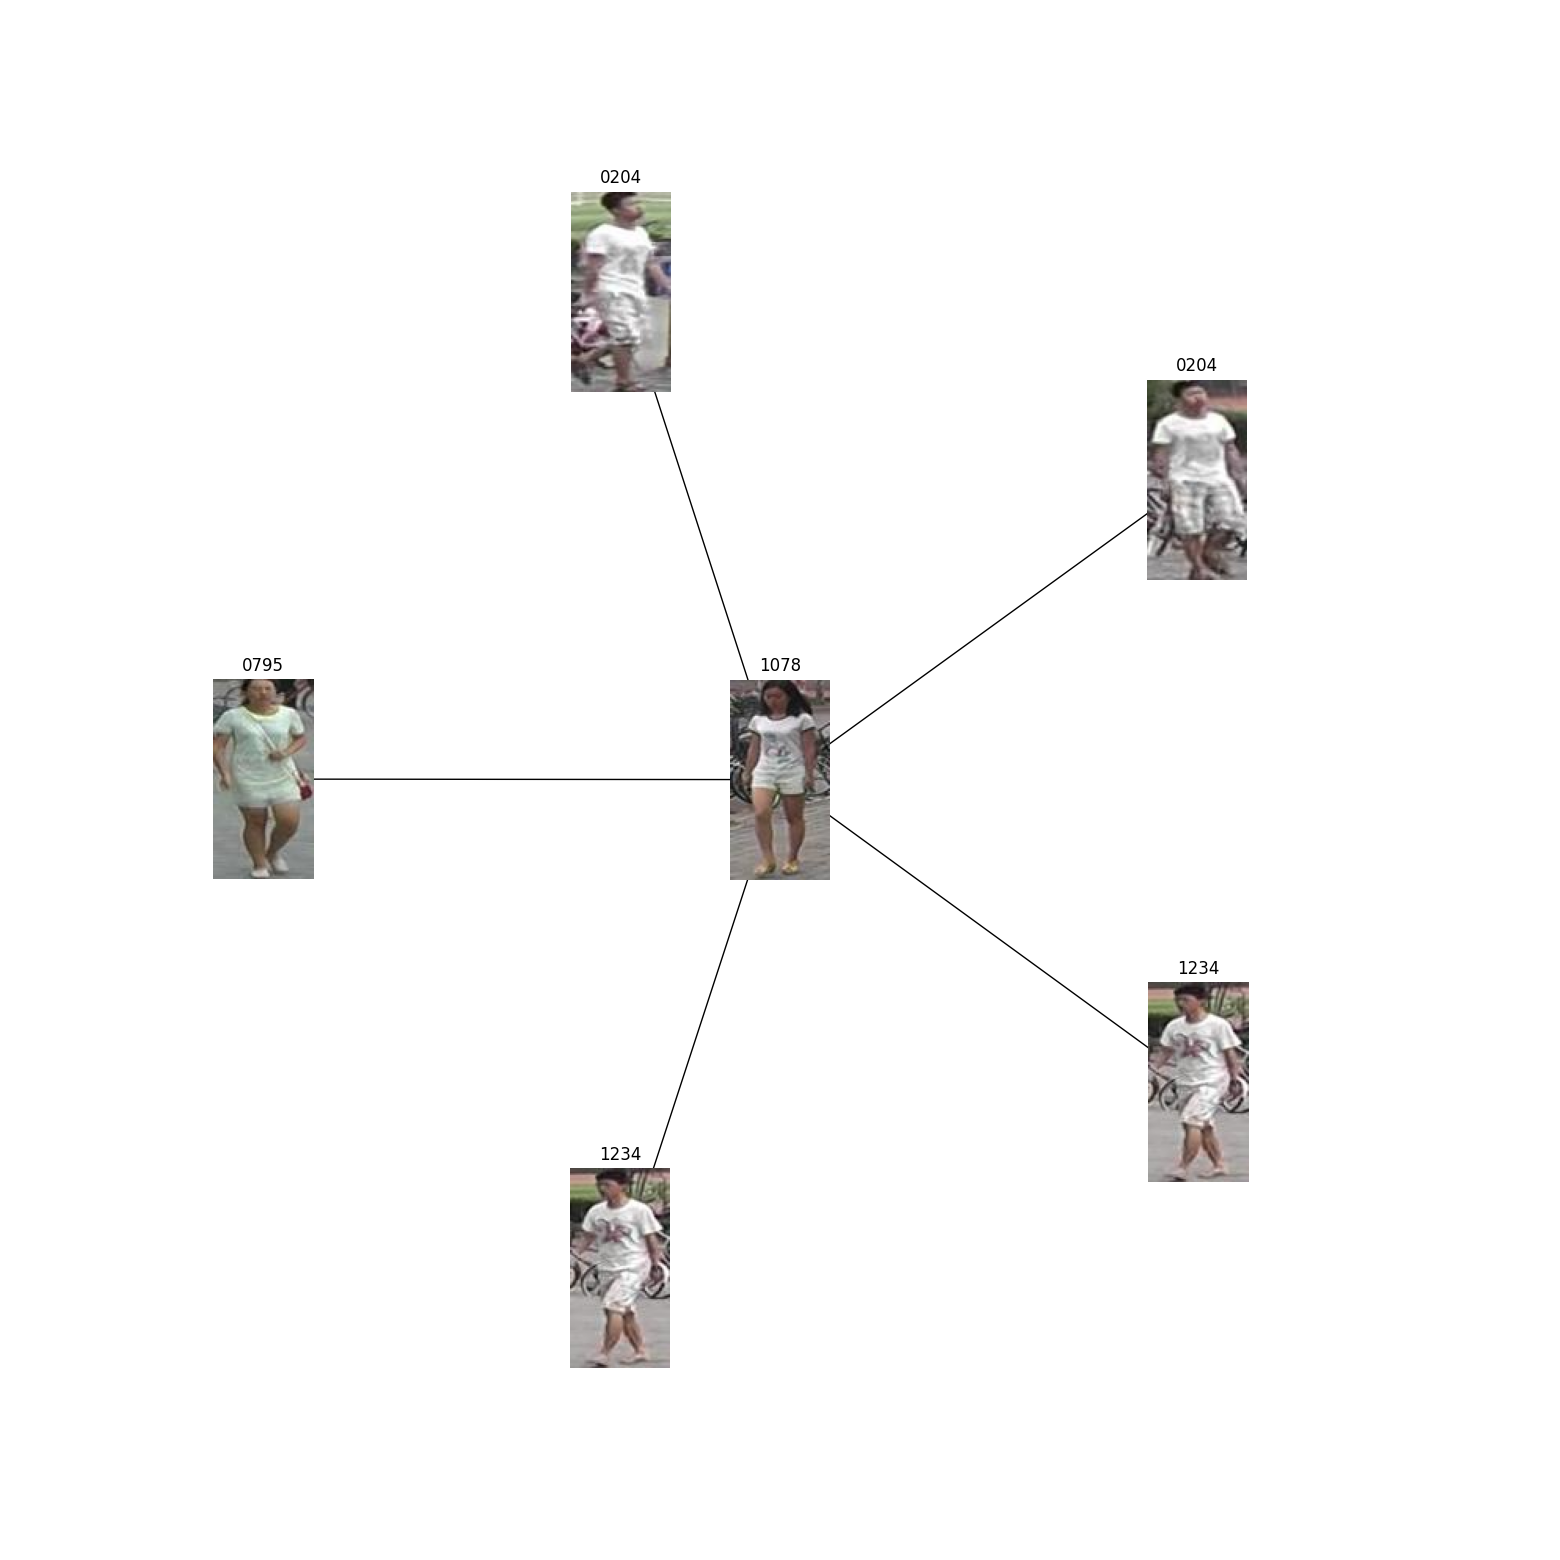

In [68]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, data_dir, img, img_path, closest_idx, distance, no_of_closest = 5);